In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter

In [2]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

In [4]:
train_df = pd.read_csv(Config.TRAIN_PATH)
train_labels = pd.read_csv(Config.TRAIN_LABELS)

In [5]:
train_labels['question'] = train_labels['session_id'].str.split('q').str[-1].astype('int8')
train_labels['session'] = train_labels['session_id'].str.split('_').str[0]
train_labels.head()

,session_id,correct,question,session
0,20090312431273200_q1,1,1,20090312431273200
1,20090312433251036_q1,0,1,20090312433251036
2,20090314121766812_q1,1,1,20090314121766812
3,20090314363702160_q1,1,1,20090314363702160
4,20090314441803444_q1,1,1,20090314441803444


In [6]:
train_labels['session'] = train_labels['session'].astype('int64')

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']
ROOMS = ['historicalsociety',
          'kohlcenter',
          'capitol_0',
          'humanecology',
          'drycleaner',
          'library',
          'capitol_1',
          'wildlife',
          'flaghouse',
          'capitol_2']

In [9]:
def groupby_apply_elapsed_time(g):
    res = {}
    diff = np.diff(g['elapsed_time'].values)
    res['elapsed_time_diff_mean'] = np.mean(diff)
    res['elapsed_time_diff_std'] = np.std(diff)
    res['elapsed_time_positive'] = len(diff[diff>0])
    res['elapsed_time_negative'] = len(diff) - res['elapsed_time_positive']
    res['start-end'] = g['elapsed_time'].values[-1] - g['elapsed_time'].values[0]
    return pd.Series(res)

In [127]:
def feature_engineer(train):
    dfs = []
    tmp = train.groupby(['session_id','level_group']).apply(groupby_apply_elapsed_time)
    dfs.append(tmp)
    for c in EVENTS:
        train[c] = (train.event_name == c)
    train['main_room'] = train['room_fqid'].str.split('.').str[1]
    for c in ROOMS:
        train[c] = (train.main_room == c)
    for c1 in ROOMS:
        for c2 in EVENTS:
            train[f'{c1}_{c2}'] = train[c1] + train[c2]
            tmp = train.groupby(['session_id','level_group'])[f'{c1}_{c2}'].sum()
            tmp.name = tmp.name + '_sum'
            dfs.append(tmp)
    for c in ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS :
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    train.drop(columns=EVENTS+ROOMS,inplace=True)

    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [128]:
%%time
df = feature_engineer(train_df)
print( df.shape )
df.head()

C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:214: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead.
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:214: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead.
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:214: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead.
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:214: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead.
  warning

(35337, 115)
CPU times: total: 2min 26s
Wall time: 2min 26s


,level_group,elapsed_time_diff_mean,elapsed_time_diff_std,elapsed_time_positive,elapsed_time_negative,start-end,historicalsociety_navigate_click_sum,historicalsociety_person_click_sum,historicalsociety_cutscene_click_sum,historicalsociety_object_click_sum,...,screen_coor_x_mean,screen_coor_y_mean,hover_duration_mean,elapsed_time_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,1188.170732,2447.579017,161.0,3.0,194860.0,153,130,132,133,...,448.410256,383.044872,2389.500000,49246.539458,-1.000000,399.296040,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,1040.446301,1985.279111,411.0,8.0,435947.0,295,317,232,246,...,442.489796,379.301020,899.925926,126666.129584,-1.000000,622.061375,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,941.525424,714.119241,291.0,4.0,277750.0,197,199,151,172,...,451.950943,378.784906,969.333333,80175.676658,-1.000000,357.227700,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,1693.855072,3504.819590,136.0,2.0,233752.0,119,105,107,115,...,358.223077,370.723077,1378.750000,67372.714092,0.000000,445.980040,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,2036.150463,10339.121375,1267.0,29.0,2638851.0,917,634,531,578,...,462.852490,387.930077,720.384921,777382.529186,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


In [129]:
for x in df.columns:
    print(x)

level_group
elapsed_time_diff_mean
elapsed_time_diff_std
elapsed_time_positive
elapsed_time_negative
start-end
historicalsociety_navigate_click_sum
historicalsociety_person_click_sum
historicalsociety_cutscene_click_sum
historicalsociety_object_click_sum
historicalsociety_map_hover_sum
historicalsociety_notification_click_sum
historicalsociety_map_click_sum
historicalsociety_observation_click_sum
historicalsociety_checkpoint_sum
kohlcenter_navigate_click_sum
kohlcenter_person_click_sum
kohlcenter_cutscene_click_sum
kohlcenter_object_click_sum
kohlcenter_map_hover_sum
kohlcenter_notification_click_sum
kohlcenter_map_click_sum
kohlcenter_observation_click_sum
kohlcenter_checkpoint_sum
capitol_0_navigate_click_sum
capitol_0_person_click_sum
capitol_0_cutscene_click_sum
capitol_0_object_click_sum
capitol_0_map_hover_sum
capitol_0_notification_click_sum
capitol_0_map_click_sum
capitol_0_observation_click_sum
capitol_0_checkpoint_sum
humanecology_navigate_click_sum
humanecology_person_click_

In [130]:
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [132]:
FEATURES = [c for c in df.columns if c not in [ 'level_group']]
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 114 features
We will train with 11779 users info


In [141]:
n_splits=20
gkf = GroupKFold(n_splits=n_splits)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)

    xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 4,
        'n_estimators': 2000,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.8,
        'colsample_bytree': 0.8,
        'min_child_weight':2,
        'alpha':15,
        'lambda':30,
        
        'use_label_encoder' : False}

    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'

        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = train_labels.loc[train_labels.question==t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = train_labels.loc[train_labels.question==t].set_index('session').loc[valid_users]

        # TRAIN MODEL
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(train_x[FEATURES].astype('float32'), train_y['correct']), (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=100)
        print(f'{t}({clf.best_ntree_limit}), ',end='')

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{i}_{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]

    print()



#########################
### Fold 1
#########################
[0]	validation_0-logloss:0.69082	validation_1-logloss:0.69049
[100]	validation_0-logloss:0.57750	validation_1-logloss:0.56485
[200]	validation_0-logloss:0.54788	validation_1-logloss:0.53275
[300]	validation_0-logloss:0.53466	validation_1-logloss:0.52022
[400]	validation_0-logloss:0.52591	validation_1-logloss:0.51394
[500]	validation_0-logloss:0.51943	validation_1-logloss:0.51027
[600]	validation_0-logloss:0.51385	validation_1-logloss:0.50781
[700]	validation_0-logloss:0.50924	validation_1-logloss:0.50618
[800]	validation_0-logloss:0.50512	validation_1-logloss:0.50489
[900]	validation_0-logloss:0.50148	validation_1-logloss:0.50386
[1000]	validation_0-logloss:0.49818	validation_1-logloss:0.50321
[1046]	validation_0-logloss:0.49675	validation_1-logloss:0.50323
1(998), [0]	validation_0-logloss:0.68420	validation_1-logloss:0.68406
[100]	validation_0-logloss:0.25150	validation_1-logloss:0.24105
[200]	validation_0-logloss:0.14179	

In [150]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.head(50)
    #Define size of bar plot
    plt.figure(figsize=(20,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [151]:
feat_imp = {}

In [152]:
for k, v in models.items():
    for x, y in zip(v.feature_importances_, v.feature_names_in_):
        if y not in feat_imp:
            feat_imp[y] = x
        else:
            feat_imp[y]+=x

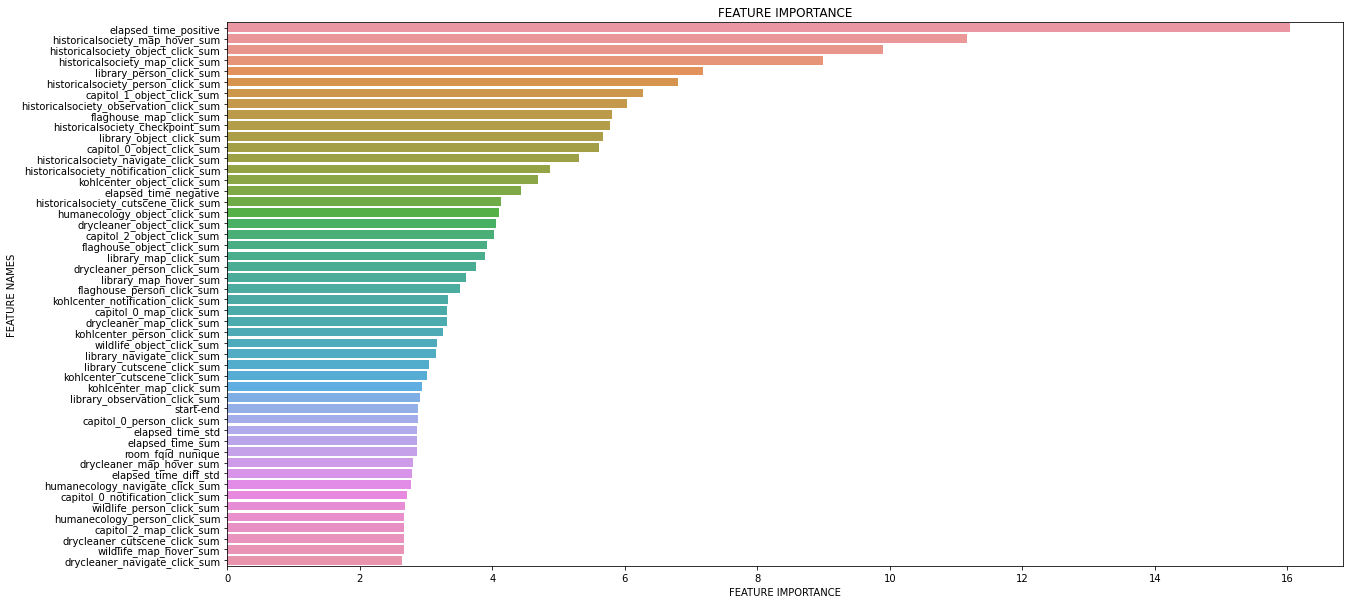

In [153]:
plot_feature_importance(list(feat_imp.values()),list(feat_imp.keys()),'')

In [154]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = train_labels.loc[train_labels.question == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [155]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

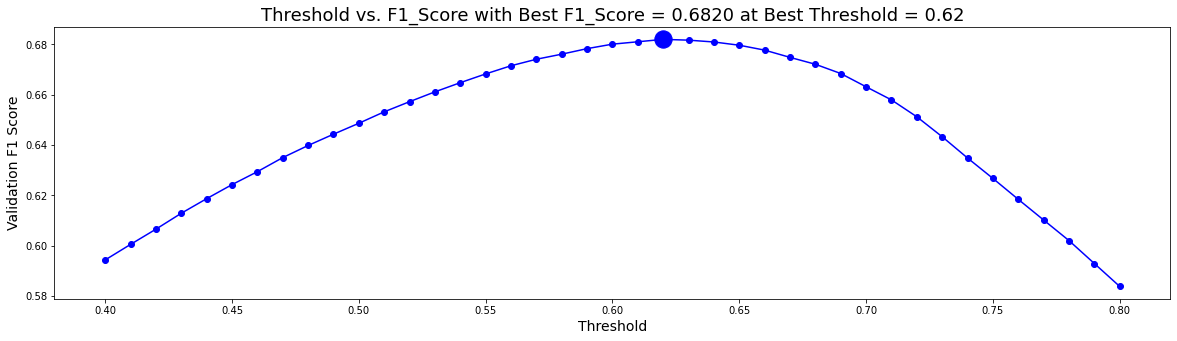

In [156]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.4f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [157]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.637916697252936
Q1: F1 = 0.4985674586786496
Q2: F1 = 0.4934485225758403
Q3: F1 = 0.6254041783818001
Q4: F1 = 0.5903734386245101
Q5: F1 = 0.6116426144228553
Q6: F1 = 0.5994784069336692
Q7: F1 = 0.5358055331400591
Q8: F1 = 0.6094170359471874
Q9: F1 = 0.5278339138658037
Q10: F1 = 0.5986093392316275
Q11: F1 = 0.5026348603216885
Q12: F1 = 0.42692317287086057
Q13: F1 = 0.6125701742805808
Q14: F1 = 0.5181229307675969
Q15: F1 = 0.4609012029887541
Q16: F1 = 0.5404661612868725
Q17: F1 = 0.49212473634530896
==> Overall F1 = 0.6820231336174167
